In [275]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set(style='whitegrid')
import math

from numpy.random import normal
from numpy.random import seed
import random

pd.options.display.max_columns = None

In [276]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# optional spatial clustering
from sklearn.cluster import DBSCAN

In [277]:
import joblib

In [278]:
ev = pd.read_csv('Resources/ev_new.csv')
print(ev.shape)
ev.columns

(257038, 15)


Index(['County', 'Latitude', 'Longitude', 'Year', 'Make', 'Model',
       'Vehicle Type', 'CAFV Eligibility', 'Year_Make_Model', 'POP_2025',
       'Median Income', 'MSRP', 'Dest. Charge', 'Tax Credit',
       'Electric Range'],
      dtype='object')

#### HDBSCAN Clustering

In [279]:
# !pip install hdbscan
# !pip install umap-learn

In [280]:
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [282]:
# Create copy
ev_df = ev.copy()
ev_df.head(2)

County  Latitude  Longitude  Year   Make    Model Vehicle Type  \
0  yakima  46.60464 -120.50729  2024  TESLA  MODEL 3          BEV   
1    king  47.53010 -122.03439  2021   AUDI   E-TRON          BEV   

  CAFV Eligibility     Year_Make_Model  POP_2025  Median Income   MSRP  \
0         Eligible  2024 TESLA MODEL 3    264650          76662  44865   
1         Eligible    2021 AUDI E-TRON   2411700         154490  65900   

   Dest. Charge  Tax Credit  Electric Range  
0          1515        5625             306  
1          1095        7500             222

In [283]:
import geopandas as gpd

gdf_ev = gpd.GeoDataFrame(
    ev,
    geometry=gpd.points_from_xy(ev["Longitude"], ev["Latitude"]),
    crs="EPSG:4326"  # WGS84 coordinate reference system (lat/lon)
)

# Shapefile for US states downloaded from Census TIGER/Line
states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")
wa = states[states["NAME"] == "Washington"]

counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_5m.zip")
wa_counties = counties[counties["STATEFP"] == "53"]

#### Clustering with HDBSCAN without PCA

In [ ]:
#  # 82s (1.37m)

# # Count number of EVs per (Longitude, Latitude) pair
# ev_counts = ev_df.groupby(['Longitude', 'Latitude']).size().reset_index(name='EV_count')
# ev_df = ev_df.merge(ev_counts, on=['Longitude', 'Latitude'], how='left')

#  Select Features (primary + secondary)
primary_features = ["County", "Median Income"]
secondary_features = ["Year", "MSRP", "Electric Range", "Vehicle Type"]

all_features = primary_features + secondary_features

X = ev_df[all_features]


# Encode Categorical features
categorical_cols = ["Vehicle Type", "County"]
numerical_cols = [col for col in all_features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols)
    ]
)

# Create pipeline:  preprocessing -> HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200
    min_samples=30
    metric='euclidean',
    cluster_selection_method='eom'
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("hdb", clusterer)
])


#  HDBSCAN
pipeline.fit(X)

labels = pipeline["hdb"].labels_
probabilities = pipeline["hdb"].probabilities_

ev_df["Cluster"] = labels
ev_df["Strength"] = probabilities

print(ev_df["Cluster"].value_counts())
print("\nNumber of clusters:", len(set(labels)) - (1 if -1 in labels else 0))  # 3165!


In [196]:
#  # 47s 

#  Select Features (primary + secondary)
primary_features = ["Latitude", "Longitude", "Median Income"]
secondary_features = ["Year", "MSRP", "Electric Range", "Vehicle Type"]

all_features = primary_features + secondary_features

X = ev_df[all_features]


# Encode Categorical features
categorical_cols = ["Vehicle Type"]
numerical_cols = [col for col in all_features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols)
    ]
)

# Create pipeline:  preprocessing -> HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=25,  # 200
    min_samples=10,  # 30
    metric='euclidean',
    cluster_selection_method='eom'
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("hdb", clusterer)
])


#  HDBSCAN
pipeline.fit(X)

labels = pipeline["hdb"].labels_
probabilities = pipeline["hdb"].probabilities_

ev_df["Cluster"] = labels
ev_df["Strength"] = probabilities

print(ev_df["Cluster"].value_counts())
print("\nNumber of clusters:", len(set(labels)) - (1 if -1 in labels else 0))  # 3184!


Cluster
-1       42967
 2550      728
 1130      683
 91        675
 456       622
         ...  
 2331       25
 820        25
 722        25
 1998       25
 116        25
Name: count, Length: 3185, dtype: int64

Number of clusters: 3184


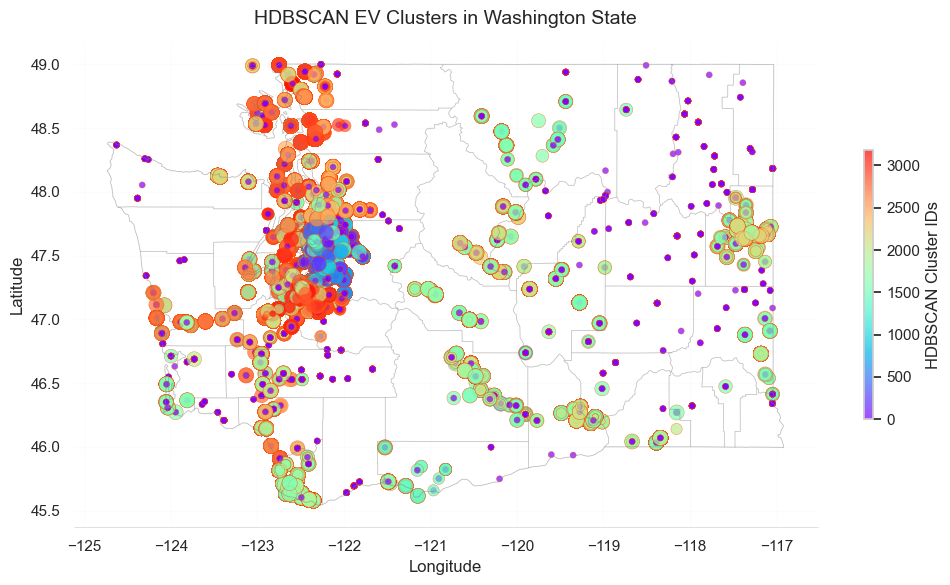

In [198]:

# SIZE = strength values from HDBSCAN
min_marker, max_marker = 20, 100
sizes = min_marker + (ev_df["Strength"] * max_marker)

# COLOR = cluster ID
cluster_values = ev_df["Cluster"]
cmap = plt.get_cmap("rainbow")  
norm = plt.Normalize(vmin=cluster_values.min(), vmax=cluster_values.max())

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Base map of counties in Washington State
wa.boundary.plot(ax=ax, color="gray", linewidth=0.6, alpha=0.3)
wa_counties.boundary.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.3)

# EV clusters
sc = ax.scatter(
    ev_df["Longitude"],
    ev_df["Latitude"],
    s=sizes,
    c=cluster_values,
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    edgecolor="orangered",
    linewidth=0.3,
)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=30)
cbar.set_label("HDBSCAN Cluster IDs")

# Titles, format
ax.set_title("HDBSCAN (Without PCA) EV-Clusters in Washington State", fontsize=14, y=1.02)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.05)

for side in ["right", "top", "left"]:
    ax.spines[side].set_visible(False)
ax.spines["bottom"].set_color("lightgray")
ax.spines["bottom"].set_linewidth(0.5)
plt.savefig("Figures/Cluster_Fig01.png")
plt.show()

#### New Approach:   PCA → UMAP → HDBSCAN pipeline

In [285]:
ev = pd.read_csv('Resources/ev_new.csv')

# Data based on EVs & Economy
econ = ev.copy()
econ.columns

Index(['County', 'Latitude', 'Longitude', 'Year', 'Make', 'Model',
       'Vehicle Type', 'CAFV Eligibility', 'Year_Make_Model', 'POP_2025',
       'Median Income', 'MSRP', 'Dest. Charge', 'Tax Credit',
       'Electric Range'],
      dtype='object')

In [288]:
shape= econ.shape[0]
tx_br0 = econ['Tax Credit'].value_counts()[0]
print(f'\nEV prices with NO Tax Credit: {shape - tx_br0}')
print(f'         Total number of EVs: {shape}')
print(f'Fraction of EVs with NO Tax Credit: {round(tx_br0/shape, 2)}\n')

shape= econ.shape[0]
dst_ch0 = econ['Dest. Charge'].value_counts()[0]
print(f'\nEV prices with NO Dest. Charge: {shape - dst_ch0}')
print(f'         Total number of EVs: {shape}')
print(f'Fraction of EVs with NO Dest. Charge: {round(dst_ch0/shape, 2)}\n')



EV prices with NO Tax Credit: 19698
         Total number of EVs: 257038
Fraction of EVs with NO Tax Credit: 0.92


EV prices with NO Dest. Charge: 36982
         Total number of EVs: 257038
Fraction of EVs with NO Dest. Charge: 0.86



In [289]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import hdbscan
import geopandas as gpd   
import plotly.express as px


In [291]:
# Flags for sparse fields rather than values: 'Dest. Charge', 'Tax Credit'

if 'Tax Credit' in econ.columns:
    econ['has_tax_credit'] = econ['Tax Credit'].notna().astype(int)
if 'Dest. Charge' in econ.columns:
    econ['has_dest_charge'] = econ['Dest. Charge'].notna().astype(int)

# Drop raw sparse columns (too many values missing)
drop_cols = []
for c in ['Tax Credit', 'Dest. Charge', 'Year_Make_Model', 'Model', 'County']:
    if c in econ.columns:
        drop_cols.append(c)
if drop_cols:
    print("Dropping columns:", drop_cols)
    econ.drop(columns=drop_cols, inplace=True, errors='ignore')
econ.columns    

Index(['Latitude', 'Longitude', 'Year', 'Make', 'Vehicle Type',
       'CAFV Eligibility', 'POP_2025', 'Median Income', 'MSRP',
       'Electric Range', 'has_tax_credit', 'has_dest_charge'],
      dtype='object')

In [292]:
# Market segmentation features (vehicle attributes)
veh_features_keep = []
for c in ['Year','Make','Electric Range',
          'MSRP','Vehicle Type','CAFV Eligibility',
          'has_tax_credit','has_dest_charge']:
    if c in econ.columns:
        veh_features_keep.append(c)

print("Vehicle features:", veh_features_keep)

# Geographic/adoption features (spatial + demography)
geo_features_keep = []
for c in ['Latitude','Longitude','Median Income','POP_2025']:
    if c in econ.columns:
        geo_features_keep.append(c)

print("Geo features:", geo_features_keep)


Vehicle features: ['Year', 'Make', 'Electric Range', 'MSRP', 'Vehicle Type', 'CAFV Eligibility', 'has_tax_credit', 'has_dest_charge']
Geo features: ['Latitude', 'Longitude', 'Median Income', 'POP_2025']


In [293]:
#  preprocess function

def preprocess_for_clustering(subEcon, categorical_cols, numeric_cols, drop_first=True):
    
    tmp = subEcon[categorical_cols + numeric_cols].copy()
    
    if len(categorical_cols) > 0:
        tmp = pd.get_dummies(tmp, columns = categorical_cols, drop_first = drop_first)

    X = tmp.select_dtypes(include=[np.number]).fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, tmp, X


#### MARKET SEGMENTATION - based on vehicle characteristics

In [294]:
# # 1725s (28.75m)

# MARKET SEGMENTATION (vehicle-only) 
print("\nMARKET SEGMENTATION using vehicle description")

cat_veh = [c for c in ['Make','Vehicle Type','CAFV Eligibility'] if c in econ.columns]
num_veh = [c for c in ['Year','Electric Range','MSRP','has_tax_credit','has_dest_charge'] if c in econ.columns]

X_scaled_veh, veh_tmp, veh_X_numeric = preprocess_for_clustering(econ[veh_features_keep], categorical_cols=cat_veh, numeric_cols=num_veh)

print("Vehicle X shape:", X_scaled_veh.shape)

# PCA before UMAP
pca_veh = PCA(n_components=min(30, X_scaled_veh.shape[1]-1), random_state=42)
X_pca_veh = pca_veh.fit_transform(X_scaled_veh)
print("PCA (veh) shape:", X_pca_veh.shape)

# UMAP
umap_veh = umap.UMAP(n_neighbors=40, min_dist=0.0, n_components=5, random_state=42)
X_umap_veh = umap_veh.fit_transform(X_pca_veh)
print("UMAP (veh) shape:", X_umap_veh.shape)

# HDBSCAN
clusterer_veh = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=50, metric='euclidean')
labels_veh = clusterer_veh.fit_predict(X_umap_veh)
print("Market clusters (unique labels):", np.unique(labels_veh)[:20])
econ['market_cluster'] = labels_veh

# Attach UMAP coords for plotting
econ['market_umap_0'] = X_umap_veh[:,0]
econ['market_umap_1'] = X_umap_veh[:,1]

joblib.dump(econ, "UMAP/market_econ_umap.joblib")

# Cluster summary (per market cluster)
def cluster_summary(econ_rows, cluster_col, features):
    agg = econ_rows.groupby(cluster_col).agg({**{f:'median' for f in features}, **{'Year':'median'}}).fillna(0)
    agg['count'] = econ_rows.groupby(cluster_col).size()
    return agg.sort_values('count', ascending=False)

print("\nMarket cluster summary (top clusters):")
veh_summary = cluster_summary(econ, 'market_cluster', ['MSRP','Electric Range'])

joblib.dump(veh_summary, "UMAP/veh_summary_umap.joblib")
display(veh_summary.head(15))


MARKET SEGMENTATION using vehicle description
Vehicle X shape: (257038, 5)
PCA (veh) shape: (257038, 4)
UMAP (veh) shape: (257038, 5)
Market clusters (unique labels): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]

Market cluster summary (top clusters):


MSRP  Electric Range    Year  count
market_cluster                                        
 29             43990.0           260.0  2023.0  18371
-1              53900.0            54.0  2022.0  11603
 4              48365.0           287.0  2024.0   9800
 57             65990.0           330.0  2022.0   7496
 17             40240.0           272.0  2023.0   7150
 36             54657.0           318.0  2021.0   6951
 152            35000.0           215.0  2018.0   6212
 47             46990.0           272.0  2022.0   4982
 10             44990.0           335.0  2025.0   4971
 6              44865.0           306.0  2024.0   4272
 39             36200.0           220.0  2019.0   3898
 31             47657.0           310.0  2021.0   3883
 24             42490.0           363.0  2025.0   3662
 2              44990.0           327.0  2026.0   3539
 51             37495.0           209.0  2023.0   2692

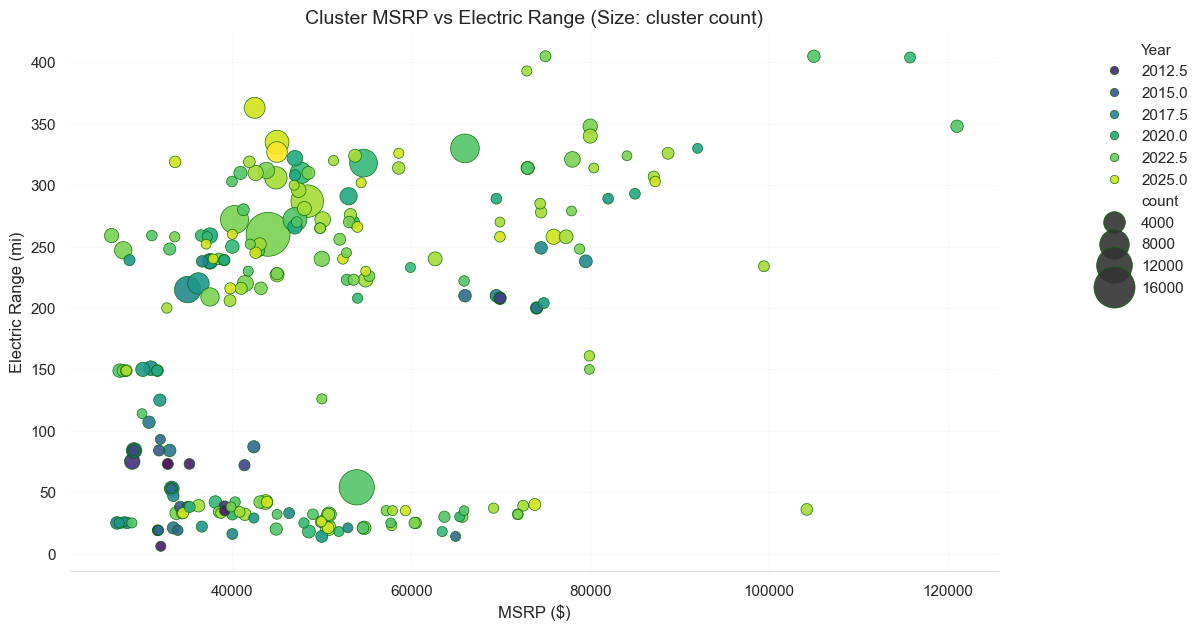

In [315]:
import matplotlib.pyplot as plt
import seaborn as sns

veh_summary = joblib.load("UMAP/veh_summary_umap.joblib")

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=veh_summary,
    x='MSRP',
    y='Electric Range',
    size='count',
    hue='Year',
    palette='viridis',
    sizes=(50, 1000),
    alpha=0.9,
    edgecolor='darkgreen',
    linewidths=0.5,
)

plt.title('Cluster MSRP vs Electric Range (Size: cluster count)', fontsize=14)
plt.xlabel('MSRP ($)')
plt.ylabel('Electric Range (mi)')
plt.legend(frameon=False, loc=(1.1, 0.5))
plt.grid(True, alpha=0.1)

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')

plt.savefig("Figures/Cluster_Fig02.png")
plt.show()

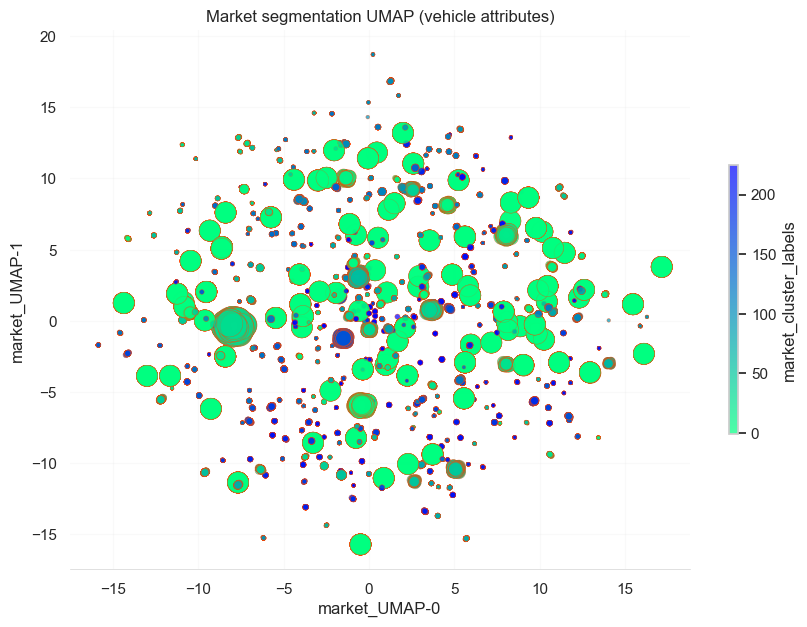

In [316]:
# Visualize UMAP for market clusters
plt.figure(figsize=(10,7))

econ = joblib.load("UMAP/market_econ_umap.joblib")

sample_idx = econ.sample(n=min(40000, len(econ)), random_state=42).index
sizes = econ.loc[sample_idx, 'market_cluster'].map(econ.groupby('market_cluster').size())

plt.scatter(
            econ.loc[sample_idx, 'market_umap_0'], 
            econ.loc[sample_idx, 'market_umap_1'],
            c=econ.loc[sample_idx, 'market_cluster'], 
            cmap='winter_r', 
            s=sizes / 50,
            edgecolor='orangered',
            linewidths=0.3,
            alpha=0.7,
            )

plt.title('Market segmentation UMAP (vehicle attributes)')
plt.colorbar(label='market_cluster_labels', shrink=0.5, aspect=30)
plt.xlabel("market_UMAP-0")
plt.ylabel("market_UMAP-1")

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.grid(True, alpha=0.1)

plt.savefig("Figures/Cluster_Fig03.png")
plt.show()


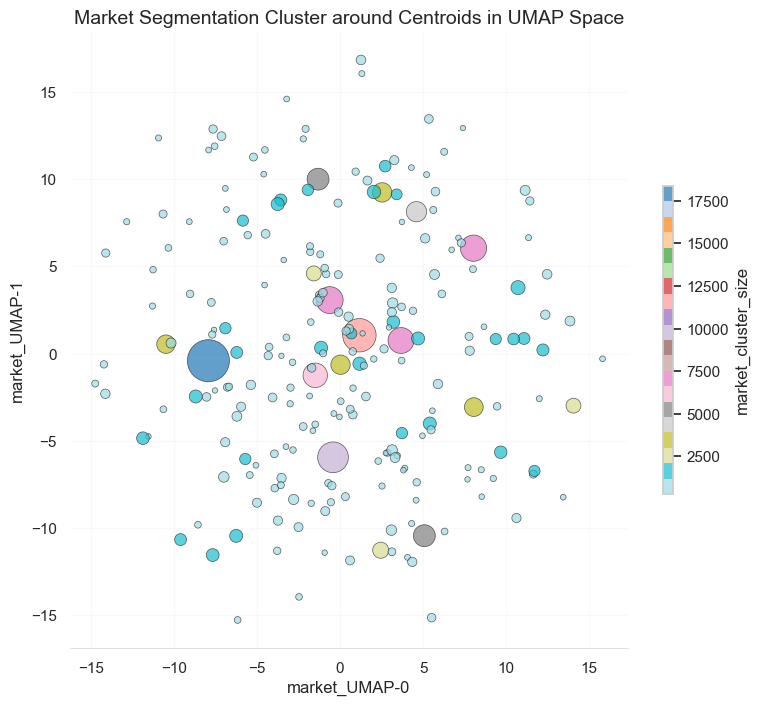

In [317]:
plt.figure(figsize=(9, 8))

econ = joblib.load("UMAP/market_econ_umap.joblib")

cluster_sizes = econ.groupby('market_cluster').size()
centroids = econ.groupby('market_cluster')[['market_umap_0', 'market_umap_1']].mean() # Compute Centroids
centroids['size'] = centroids.index.map(cluster_sizes)

scatter = plt.scatter(
    centroids['market_umap_0'],
    centroids['market_umap_1'],
    s=centroids['size'] / 20,      # scale size
    c=centroids['size'],
    cmap='tab20_r',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

plt.title("Market Segmentation Cluster around Centroids in UMAP Space", fontsize=14)
plt.xlabel("market_UMAP-0")
plt.ylabel("market_UMAP-1")
plt.colorbar(scatter, label='market_cluster_size', shrink=0.5, aspect=30)

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.grid(True, alpha=0.1)

plt.savefig("Figures/Cluster_Fig04.png")
plt.show()

##### Clusters dominated by BEVs
###### Rural areas has PHEV-heavy clusters
###### Mixed areas

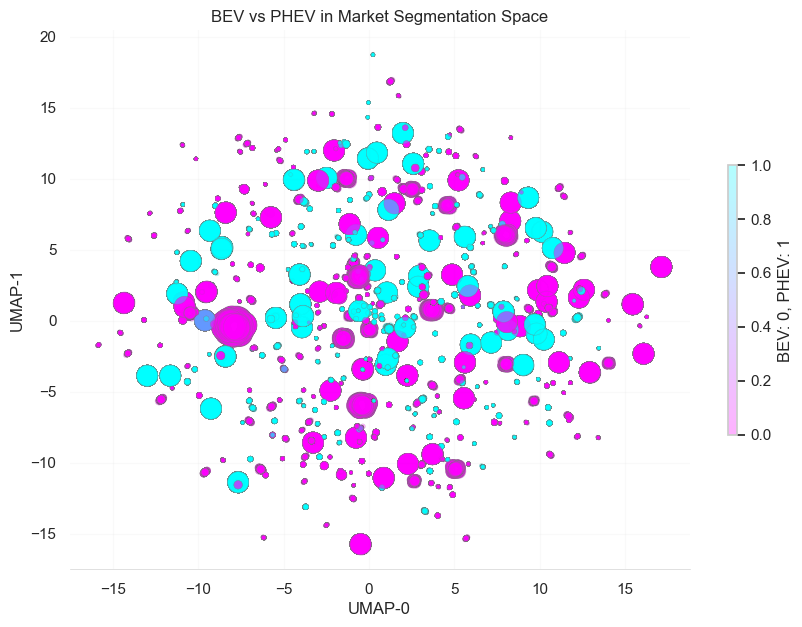

In [318]:
plt.figure(figsize=(10, 7))

econ = joblib.load("UMAP/market_econ_umap.joblib")

cluster_sizes = econ.groupby('market_cluster').size()
sizes_all = econ['market_cluster'].map(cluster_sizes)  # Bubble size

# BEV/PHEV  numeric labels
type_map = {'BEV': 0, 'PHEV': 1}
type_values = econ['Vehicle Type'].map(type_map)

plt.scatter(
    econ['market_umap_0'],
    econ['market_umap_1'],
    c=type_values,
    cmap='cool_r',
    s= sizes_all/50,
    alpha=0.3,
    edgecolor='gray',
    linewidths=0.3
)

plt.title("BEV vs PHEV in Market Segmentation Space")
plt.colorbar(label="BEV: 0, PHEV: 1", shrink=0.5, aspect=30)
plt.xlabel("UMAP-0")
plt.ylabel("UMAP-1")

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.grid(True, alpha=0.1)

plt.savefig("Figures/Cluster_Fig05.png")
plt.show()

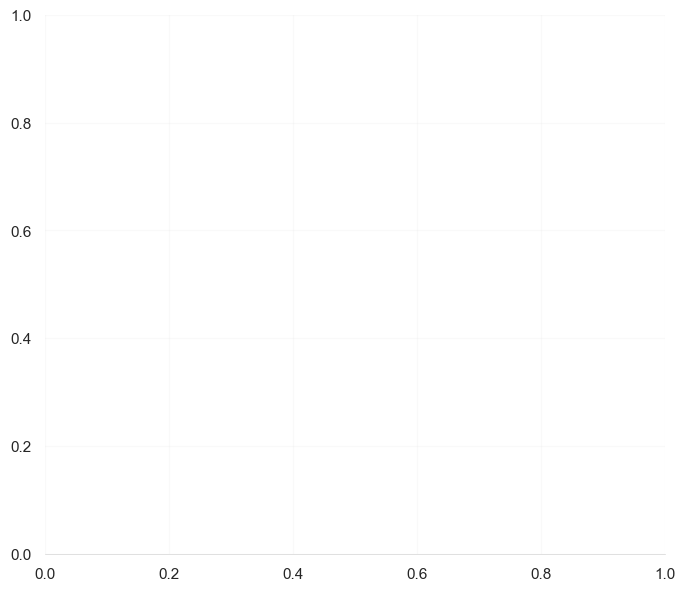

In [319]:
from matplotlib.animation import FuncAnimation

econ = joblib.load("UMAP/market_econ_umap.joblib")
econ['Year'] = econ['Year'].astype(int)
years = sorted(econ['Year'].unique())

fig, ax = plt.subplots(figsize=(8, 7)) 

def update(i):
    ax.clear()
    year = years[i]  # i is index of the frame
    sub = econ[econ['Year'] == year]

    ax.scatter(
        sub['market_umap_0'],
        sub['market_umap_1'],
        c=sub['market_cluster'],
        s=40,
        cmap='winter_r',
        alpha=0.6,
        edgecolor='darkgreen',
        linewidths=0.3,
    )
    ax.set_title(f"EV Market Clusters in Year {year}", fontsize=14)
    ax.set_xlabel("UMAP-0")
    ax.set_ylabel("UMAP-1")
       
ani = FuncAnimation(fig, update, frames=len(years), interval=1000)    

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.grid(True, alpha=0.1)

plt.show()

from IPython.display import HTML
HTML(ani.to_jshtml())


In [320]:
econ = joblib.load("UMAP/market_econ_umap.joblib")

cluster_summary = econ.groupby('market_cluster').agg({
    'MSRP': 'median',
    'Electric Range': 'median',
    'Year': 'median',
    'Make': lambda x: x.value_counts().index[0],
    'Vehicle Type': lambda x: x.value_counts().index[0],
    'CAFV Eligibility': lambda x: x.value_counts().index[0],
    'Median Income': 'median',
    'POP_2025': 'median',
}).reset_index()

cluster_sizes = econ.groupby('market_cluster').size()
cluster_summary['Cluster_size'] = econ['market_cluster'].map(cluster_sizes)  # Bubble size

joblib.dump(cluster_summary, "UMAP/cluster_summary_umap.joblib")
cluster_summary

market_cluster      MSRP  Electric Range    Year           Make  \
0                -1   53900.0            54.0  2022.0  MERCEDES-BENZ   
1                 0   49995.0           240.0  2023.0           FORD   
2                 1   28980.0            84.0  2014.0         NISSAN   
3                 2   44990.0           327.0  2026.0          TESLA   
4                 3   41900.0           319.0  2024.0      CHEVROLET   
..              ...       ...             ...     ...            ...   
222             221   99400.0           234.0  2024.0        PORSCHE   
223             222   79900.0           161.0  2024.0         RIVIAN   
224             223   31620.0           149.0  2021.0         NISSAN   
225             224   79900.0           150.0  2023.0         RIVIAN   
226             225  104200.0            36.0  2024.0        PORSCHE   

    Vehicle Type CAFV Eligibility  Median Income   POP_2025  Cluster_size  
0           PHEV         Eligible       154490.0  2411700.0          4272  
1            BEV         Eligible       111908.0   873800.0          1424  
2            BEV         Eligible       154490.0  2411700.0           513  
3            BEV         Eligible       154490.0  2411700.0          1789  
4            BEV         Eligible       114590.0   873800.0          6951  
..           ...              ...            ...        ...           ...  
222          BEV         Eligible       154490.0  2411700.0          9800  
223          BEV     Not Eligible       111126.0   959900.0          1357  
224          BEV     Not Eligible       154490.0  2411700.0          1357  
225          BEV     Not Eligible       154490.0  2411700.0          1307  
226         PHEV         Eligible       154490.0  2411700.0           541  

[227 rows x 10 columns]

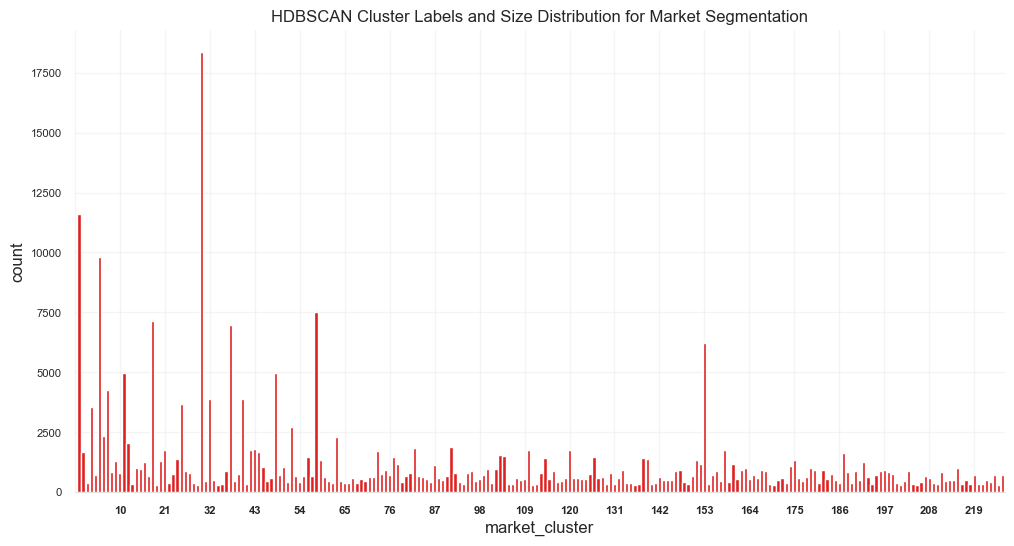

In [321]:
plt.figure(figsize=(12, 6))
market_econ = joblib.load("UMAP/market_econ_umap.joblib")

sns.countplot(x=market_econ["market_cluster"], color='red', alpha=1.0)
plt.title("HDBSCAN Cluster Labels and Size Distribution for Market Segmentation")
plt.xticks(ticks=plt.xticks()[0], labels=[int(t) for t in plt.xticks()[0]])
xticks = np.arange(min(market_econ["market_cluster"]), max(market_econ["market_cluster"])+2, 11)
plt.xticks(xticks, fontsize=8, fontweight='bold')
plt.yticks(fontsize=8)

[plt.gca().spines[side].set_visible(False) for side in ['right', 'top', 'left']]
plt.gca().spines['bottom'].set_linewidth(0.5), plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(alpha=0.2)
plt.savefig("Figures/Cluster_Fig14.png")
plt.show()

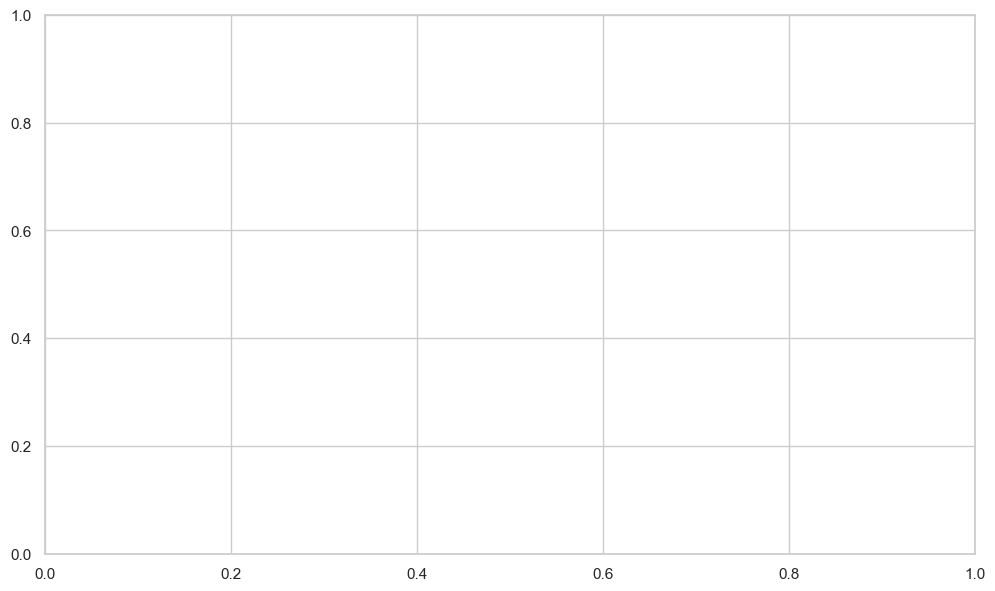

In [304]:

from matplotlib.animation import FuncAnimation
from IPython.display import HTML


cluster_summary = joblib.load("UMAP/cluster_summary_umap.joblib")

cluster_summary['Year'] = cluster_summary['Year'].astype(int)

years = sorted(cluster_summary['Year'].unique())

palette_dict = {
    'BEV': 'limegreen',
    'PHEV': 'orangered'
}

fig, ax = plt.subplots(figsize=(12, 7))

def update(i):
    ax.clear()
    year = years[i]
    sub = cluster_summary[cluster_summary['Year'] == year]

    sns.scatterplot(
        data=sub,
        x='Electric Range',
        y='MSRP',
        hue='Vehicle Type',
        style='CAFV Eligibility',
        size=sub['Cluster_size'] / 20,
        palette=palette_dict,
        sizes=(20, 300),
        edgecolor='white',
        linewidth=0.8,
        ax=ax
    )

    ax.set_title(f"Electric Range vs MSRP – Year {year}", fontsize=14)
    ax.set_xlabel("Electric Range")
    ax.set_ylabel("MSRP")

    for side in ['right', 'top', 'left']:
        ax.spines[side].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('lightgray')
    ax.grid(True, alpha=0.1)

    # Move legend to right
    ax.legend(loc=(1.05, 0.5), frameon=False, fontsize=10)

ani = FuncAnimation(fig, update, frames=len(years), interval=1200)

plt.show()
HTML(ani.to_jshtml())


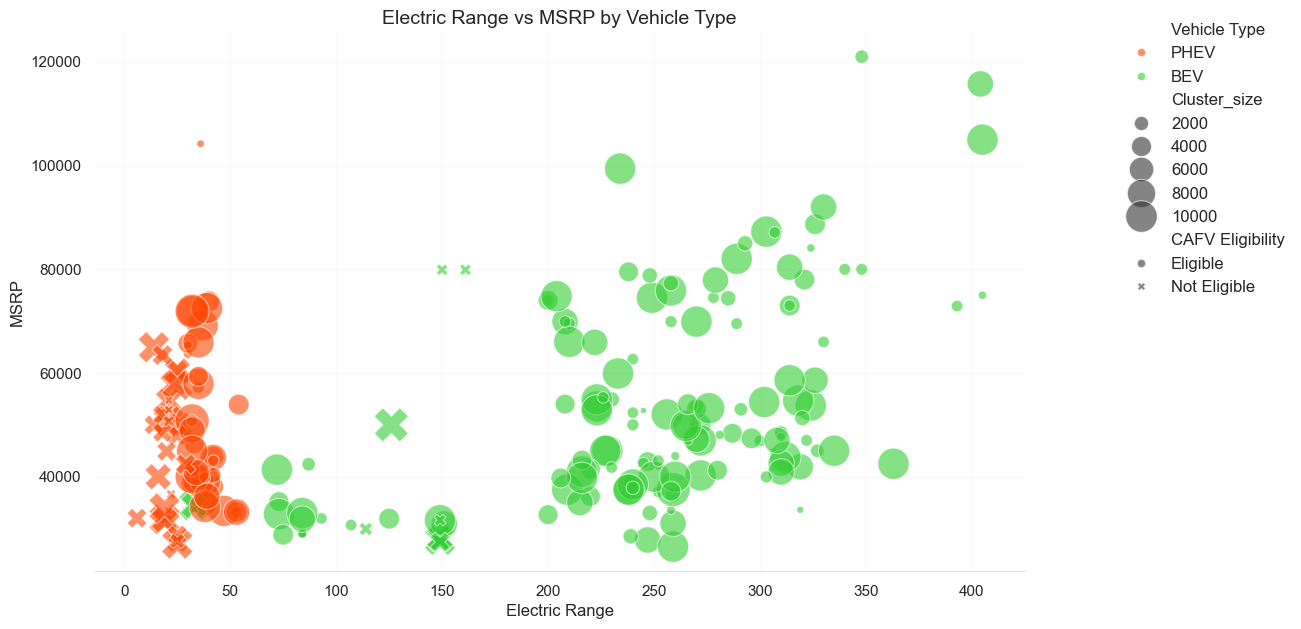

In [305]:

cluster_summary = joblib.load("UMAP/cluster_summary_umap.joblib")

plt.figure(figsize=(12,7))
palette_dict = {
    'BEV': 'limegreen',
    'PHEV': 'orangered'
}

sns.scatterplot(
    data=cluster_summary,
    x='Electric Range', 
    y='MSRP', 
    hue='Vehicle Type', 
    style= 'CAFV Eligibility', 
    size='Cluster_size',
    palette=palette_dict,
    sizes=(20, 600),
    edgecolor='white',
    alpha = 0.6,
    linewidth=0.8    
)

plt.title("Electric Range vs MSRP by Vehicle Type", fontsize=14)
plt.legend(loc=(1.1, 0.5), frameon = False, fontsize=12)

ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.grid(True, alpha=0.1)

plt.savefig("Figures/Cluster_Fig06.png")
plt.show()

#### GEOGRAPHIC SEGMENTATION - Based on Geo-Economic Factors

In [306]:
# # 1699s (28.32m)

# GEOGRAPHIC / ADOPTION CLUSTERING

print("\nGeographic / Adoption segmentation")

cat_geo = []  
num_geo = geo_features_keep

# subset to geocoded rows
geo_econ = econ.dropna(subset=['Latitude','Longitude']).copy()
X_scaled_geo, geo_tmp, geo_X = preprocess_for_clustering(geo_econ, categorical_cols=cat_geo, numeric_cols=num_geo)
print("Geo X shape:", X_scaled_geo.shape)

pca_geo = PCA(n_components=min(15, X_scaled_geo.shape[1]-1), random_state=42)
X_pca_geo = pca_geo.fit_transform(X_scaled_geo)
umap_geo = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=3, random_state=42)
X_umap_geo = umap_geo.fit_transform(X_pca_geo)

clusterer_geo = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=20)
labels_geo = clusterer_geo.fit_predict(X_umap_geo)
geo_econ['geo_cluster'] = labels_geo

# map back to main df by index
econ.loc[geo_econ.index, 'geo_cluster'] = labels_geo
econ['geo_umap_0'] = np.nan; econ['geo_umap_1'] = np.nan; econ['geo_umap_2'] = np.nan
econ.loc[geo_econ.index, 'geo_umap_0'] = X_umap_geo[:,0]
econ.loc[geo_econ.index, 'geo_umap_1'] = X_umap_geo[:,1]
econ.loc[geo_econ.index, 'geo_umap_2'] = X_umap_geo[:,2]

geo_econ['geo_umap_0'] = X_umap_geo[:,0]
geo_econ['geo_umap_1'] = X_umap_geo[:,1]
geo_econ['geo_umap_2'] = X_umap_geo[:,2]

joblib.dump(geo_econ, "UMAP/geo_econ_umap.joblib")

cluster_sizes = pd.Series(labels_geo).value_counts()

# map each point’s cluster to its size
sizes = geo_econ['geo_cluster'].map(cluster_sizes)

# Income summary by geo cluster
if 'Median Income' in geo_econ.columns:
    inc = geo_econ.groupby('geo_cluster')['Median Income'].agg(['median','mean','count']).sort_values('median', ascending=False)
    display(inc.head(15))



Geographic / Adoption segmentation
Geo X shape: (257038, 4)


median      mean  count
geo_cluster                           
273          154490.0  154490.0   2077
40           154490.0  154490.0   1217
93           154490.0  154490.0   6268
92           154490.0  154490.0   2869
80           154490.0  154490.0   3958
79           154490.0  154490.0   3424
78           154490.0  154490.0   1045
77           154490.0  154490.0   1969
60           154490.0  154490.0    527
59           154490.0  154490.0   3747
58           154490.0  154490.0   1110
57           154490.0  154490.0    384
272          154490.0  154490.0    156
47           154490.0  154490.0   3061
46           154490.0  154490.0    461

#### Clusters in UMAP feature-space

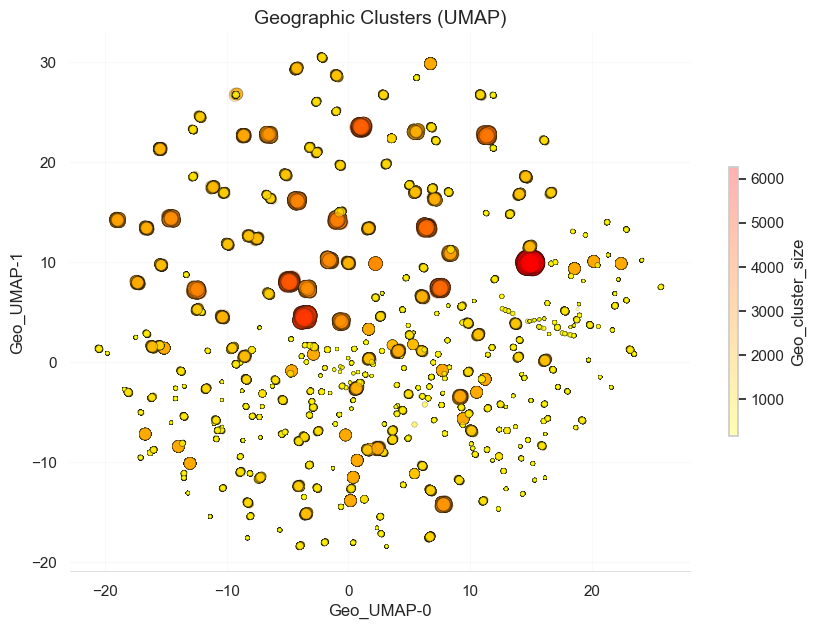

In [307]:
import matplotlib.patches as mpatches

geo_econ = joblib.load("UMAP/geo_econ_umap.joblib")

plt.figure(figsize=(10, 7))

cluster_sizes = geo_econ['geo_cluster'].value_counts()
sizes = geo_econ['geo_cluster'].map(cluster_sizes)
scaled_sizes = sizes.clip(upper=500) / 10  # Cap to 500 points

sc = plt.scatter(
    geo_econ['geo_umap_0'],
    geo_econ['geo_umap_1'],
    c=sizes,
    s=sizes/30, 
    cmap='autumn_r',
    alpha=0.3,
    edgecolor='k',
    linewidths=0.3
)

plt.colorbar(sc, label='Geo_cluster_size', shrink=0.5, aspect=30)
plt.title("Geographic Clusters (UMAP)", fontsize=14)
plt.xlabel("Geo_UMAP-0")
plt.ylabel("Geo_UMAP-1")

unique_clusters = sorted(geo_econ['geo_cluster'].unique())
patches = [
    mpatches.Patch(
        color=plt.cm.viridis_r((cl+1) / (len(unique_clusters)+1)),
        label=f"Cluster {cl}"
    )
    for cl in unique_clusters if cl != -1
]

# Add the noise cluster (-1) as magenta
if -1 in unique_clusters:
    patches.append(mpatches.Patch(color="magenta", label="Noise (-1)"))

plt.grid(True, alpha=0.1)
[plt.gca().spines[side].set_visible(False) for side in ['right', 'top', 'left']]
plt.gca().spines['bottom'].set_linewidth(0.5), plt.gca().spines['bottom'].set_color('lightgray')
plt.savefig("Figures/Cluster_Fig07.png")
plt.show()

#### Clusters in actual grographic locations

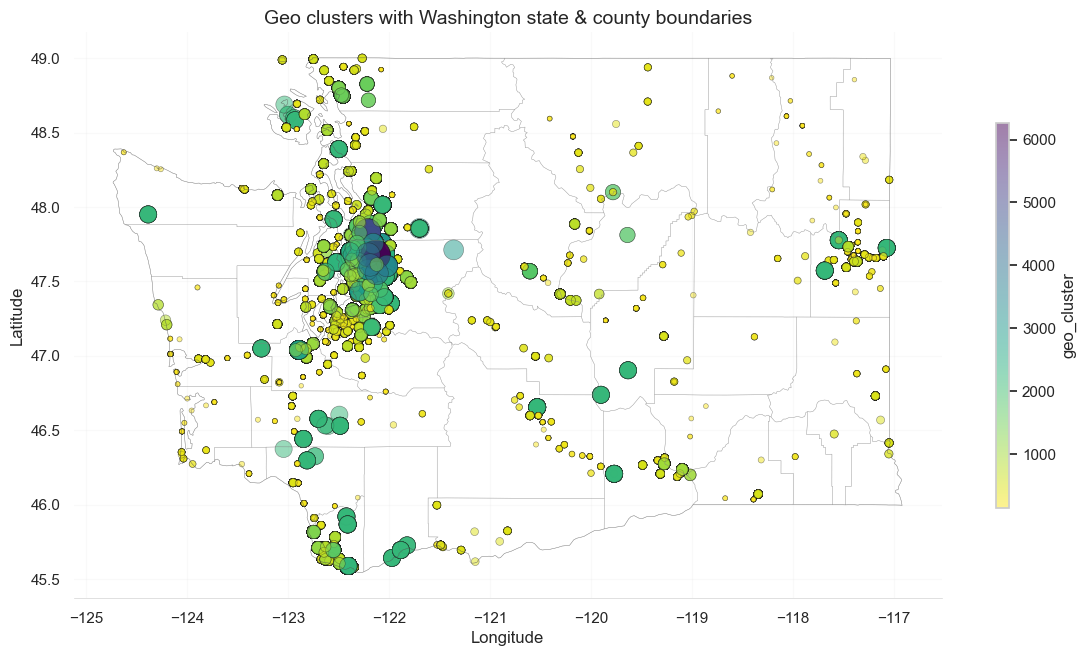

In [308]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(14, 10))

# Plot Washington state boundary
wa.boundary.plot(ax=ax, color="k", linewidth=0.3, alpha=0.5)

# Plot county boundaries
wa_counties.boundary.plot(ax=ax, color="gray", linewidth=0.3, alpha=0.5)

# Plot your points on the same axes
sample_idx = geo_econ.sample(n=min(50000, len(geo_econ)), random_state=42).index
sc = ax.scatter(
    geo_econ.loc[sample_idx,'Longitude'], 
    geo_econ.loc[sample_idx,'Latitude'],
    c=sizes.loc[sample_idx], 
    # c=geo_econ.loc[sample_idx,'geo_cluster'],
    s=sizes.loc[sample_idx] * 0.07,
    cmap='viridis_r',
    alpha=0.5,
    edgecolor='k',
    linewidths=0.4
)

# Colorbar for clusters
plt.colorbar(sc, label='geo_cluster', ax=ax, shrink=0.5, aspect=30)

# Labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geo clusters with Washington state & county boundaries', fontsize=14)

ax.grid(True, alpha=0.1)
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')
plt.savefig("Figures/Cluster_Fig08.png")

plt.show()

#### HDBSCAN Cluster labels

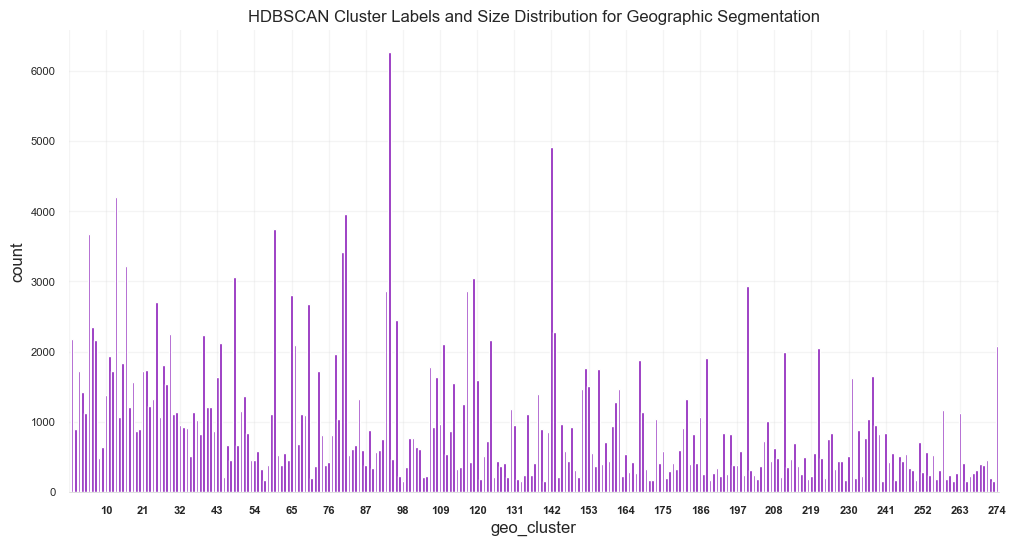

In [309]:
plt.figure(figsize=(12, 6))
geo_econ = joblib.load("UMAP/geo_econ_umap.joblib")

sns.countplot(x=geo_econ["geo_cluster"], color='darkviolet', alpha=1.0)
plt.title("HDBSCAN Cluster Labels and Size Distribution for Geographic Segmentation")
plt.xticks(ticks=plt.xticks()[0], labels=[int(t) for t in plt.xticks()[0]])
xticks = np.arange(min(geo_econ["geo_cluster"]), max(geo_econ["geo_cluster"])+2, 11)
plt.xticks(xticks, fontsize=8, fontweight='bold')
plt.yticks(fontsize=8)

[plt.gca().spines[side].set_visible(False) for side in ['right', 'top', 'left']]
plt.gca().spines['bottom'].set_linewidth(0.5), plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(alpha=0.2)
plt.savefig("Figures/Cluster_Fig09.png")
plt.show()

In [310]:

geo_econ = joblib.load("UMAP/geo_econ_umap.joblib")

# Compute medians and mode for categorical
geo_cluster_summary = geo_econ.groupby('geo_cluster').agg({

    # Vehicle features
    'Year': 'median',
    'Make': lambda x: x.value_counts().index[0],
    'Electric Range': 'median',
    'MSRP': 'median',
    'Vehicle Type': lambda x: x.value_counts().index[0],
    'CAFV Eligibility': lambda x: x.value_counts().index[0],
    'has_tax_credit': 'median',
    'has_dest_charge': 'median',

    # Geographic features
    'Latitude': 'median',
    'Longitude': 'median',
    'Median Income': 'median',
    'POP_2025': 'median',

}).reset_index()

cluster_sizes = geo_econ.groupby('geo_cluster').size()
geo_cluster_summary['Cluster_size'] = geo_econ['geo_cluster'].map(cluster_sizes)  # Bubble size

joblib.dump(geo_cluster_summary, "UMAP/geo_cluster_summary_umap.joblib")

geo_cluster_summary

geo_cluster    Year   Make  Electric Range     MSRP Vehicle Type  \
0             -1  2023.0  TESLA           258.0  44990.0          BEV   
1              0  2023.0  TESLA           260.0  44865.0          BEV   
2              1  2023.0  TESLA           245.0  44990.0          BEV   
3              2  2022.0  TESLA           240.0  43990.0          BEV   
4              3  2023.0  TESLA           260.0  44990.0          BEV   
..           ...     ...    ...             ...      ...          ...   
270          269  2023.0  TESLA           258.0  46250.0          BEV   
271          270  2023.0  TESLA           239.0  43865.0          BEV   
272          271  2022.0  TESLA           241.5  45705.0          BEV   
273          272  2023.0  TESLA           260.0  44990.0          BEV   
274          273  2023.0  TESLA           266.0  44995.0          BEV   

    CAFV Eligibility  has_tax_credit  has_dest_charge  Latitude  Longitude  \
0           Eligible             1.0              1.0  47.54748 -122.00292   
1           Eligible             1.0              1.0  47.30151 -122.33030   
2           Eligible             1.0              1.0  45.69345 -122.55149   
3           Eligible             1.0              1.0  47.67597 -122.38591   
4           Eligible             1.0              1.0  47.30740 -122.23035   
..               ...             ...              ...       ...        ...   
270         Eligible             1.0              1.0  47.59820 -120.65754   
271         Eligible             1.0              1.0  45.72776 -121.48704   
272         Eligible             1.0              1.0  46.55351 -120.47780   
273         Eligible             1.0              1.0  47.54748 -122.00292   
274         Eligible             1.0              1.0  47.54748 -122.00292   

     Median Income   POP_2025  Cluster_size  
0         104191.0   288900.0           190  
1         154490.0  2411700.0          2250  
2         108973.0   542400.0          1120  
3         154490.0  2411700.0           321  
4         154490.0  2411700.0          2811  
..             ...        ...           ...  
270        91893.0    82900.0          1120  
271        86578.0    23600.0          2701  
272        76662.0   264650.0          2681  
273       154490.0  2411700.0          1473  
274       154490.0  2411700.0          3747  

[275 rows x 14 columns]

In [311]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load datasets
econ = joblib.load("market_econ_umap.joblib")      # vehicle features only
geo_econ = joblib.load("UMAP/geo_econ_umap.joblib")  # geographic features + geo_cluster

# Drop overlapping columns from geo_econ
overlap = set(econ.columns).intersection(set(geo_econ.columns))
geo_econ_clean = geo_econ.drop(columns=overlap, errors='ignore')

# Concatenate market + geo features
full = pd.concat([econ, geo_econ_clean], axis=1)

# Define features and label
features = veh_features_keep + geo_features_keep
X = full[features].copy()
y = full["geo_cluster"]

# check labels for uniqueness
labels = sorted(y.unique())
print("Cluster labels:\n", labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Preprocessing
categorical = ['Make', 'Vehicle Type', 'CAFV Eligibility']
numerical = list(set(features) - set(categorical))

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

# Fit preprocessing and transform
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

# Save preprocessed arrays + labels
joblib.dump(X_train_prep, "UMAP/X_train_prep.joblib")
joblib.dump(X_test_prep, "UMAP/X_test_prep.joblib")
joblib.dump(y_train, "UMAP/y_train.joblib")
joblib.dump(y_test, "UMAP/y_test.joblib")

joblib.dump(preprocess, "UMAP/preprocess_pipeline.joblib")

Cluster labels:
 [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217

['UMAP/preprocess_pipeline.joblib']

In [312]:
import joblib

X_train = joblib.load("UMAP/X_train_prep.joblib")
X_test  = joblib.load("UMAP/X_test_prep.joblib")
y_train = joblib.load("UMAP/y_train.joblib")
y_test  = joblib.load("UMAP/y_test.joblib")

X_train.shape, X_test.shape

((192778, 59), (64260, 59))

### Random Forest Classifier for HDBSCAN clusters

#### Baseline Random Forest

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [314]:
# 637s (10.62m)
rf = RandomForestClassifier(
    n_estimators=200,       # strong but not too slow
    max_depth=None,        # allow full depth
    n_jobs=-1,             # use all cores
    class_weight="balanced", # good for cluster imbalance
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

#### Evaluation

In [329]:
# 61s
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8769530034235916
              precision    recall  f1-score   support

          -1       1.00      0.03      0.07       547
           0       0.87      0.89      0.88       226
           1       0.99      1.00      0.99       431
           2       0.90      0.92      0.91       357
           3       0.88      0.88      0.88       283
           4       0.96      0.90      0.93       920
           5       0.98      0.96      0.97       588
           6       0.96      0.90      0.93       543
           7       0.87      0.93      0.90       123
           8       0.77      0.91      0.83       160
           9       0.76      0.82      0.79       346
          10       0.96      0.88      0.92       485
          11       0.98      0.99      0.99       433
          12       0.94      0.95      0.95      1052
          13       0.69      0.80      0.74       267
          14       0.80      0.81      0.81       460
          15       0.98      0.95      0.97       80

#### Follow-up RF

##### MemoryError: could not allocate 72089600 bytes

In [ ]:

# # MemoryError: could not allocate 72089600 bytes
# rf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=30,
#     min_samples_leaf=5,
#     class_weight="balanced",
#     random_state=42,
#     n_jobs=-1
# )


#### Memory-safe training setup

In [323]:
# 88s

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load preprocessed data
X_train = joblib.load("UMAP/X_train_prep.joblib")
X_test  = joblib.load("UMAP/X_test_prep.joblib")
y_train = joblib.load("UMAP/y_train.joblib")
y_test  = joblib.load("UMAP/y_test.joblib")

# Random Forest - memory safe configuration
rf = RandomForestClassifier(
    n_estimators=200,        # reduce from 300
    max_depth=20,            # prevents extremely deep trees
    min_samples_leaf=5,      # reduces leaf nodes
    max_features="sqrt",     # reduces number of features considered per split
    class_weight="balanced",
    random_state=42,
    n_jobs=-1                # use all CPU cores
)

# Fit model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.884547152194211
              precision    recall  f1-score   support

          -1       1.00      0.05      0.09       547
           0       0.85      0.90      0.87       226
           1       0.98      1.00      0.99       431
           2       0.96      0.94      0.95       357
           3       0.94      0.87      0.90       283
           4       0.93      0.96      0.95       920
           5       0.98      0.96      0.97       588
           6       0.97      0.88      0.92       543
           7       0.81      0.91      0.86       123
           8       0.76      0.94      0.84       160
           9       0.84      0.88      0.86       346
          10       0.94      0.86      0.90       485
          11       0.97      0.98      0.98       433
          12       0.96      0.93      0.95      1052
          13       0.75      0.83      0.79       267
          14       0.85      0.87      0.86       460
          15       0.98      0.93      0.95       804

#### Feature importance by feature name

In [324]:
# Get Feature names
preprocess = joblib.load("UMAP/preprocess_pipeline.joblib")
feature_names = []

for name, transformer, cols in preprocess.transformers_:
    if name == 'remainder' and transformer == 'passthrough':
        continue 
        
    if hasattr(transformer, 'get_feature_names_out'):    
        names = transformer.get_feature_names_out(cols)
        feature_names.extend(names)
    else:
        # For numeric columns with StandardScaler or passthrough
        feature_names.extend(cols)

# list
feature_names = list(feature_names)
# print(feature_names[:20])

In [325]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(20))

Longitude                        0.375274
Latitude                         0.369585
Median Income                    0.084978
POP_2025                         0.082880
MSRP                             0.022725
Year                             0.019633
Electric Range                   0.018246
Make_RIVIAN                      0.002008
CAFV Eligibility_Eligible        0.001769
Make_CHRYSLER                    0.001742
CAFV Eligibility_Not Eligible    0.001603
Make_FORD                        0.001458
Make_TESLA                       0.001440
Make_CHEVROLET                   0.001382
Make_KIA                         0.001114
Make_JEEP                        0.001087
Vehicle Type_PHEV                0.001043
Vehicle Type_BEV                 0.001009
Make_BMW                         0.000967
Make_DODGE                       0.000917
dtype: float64


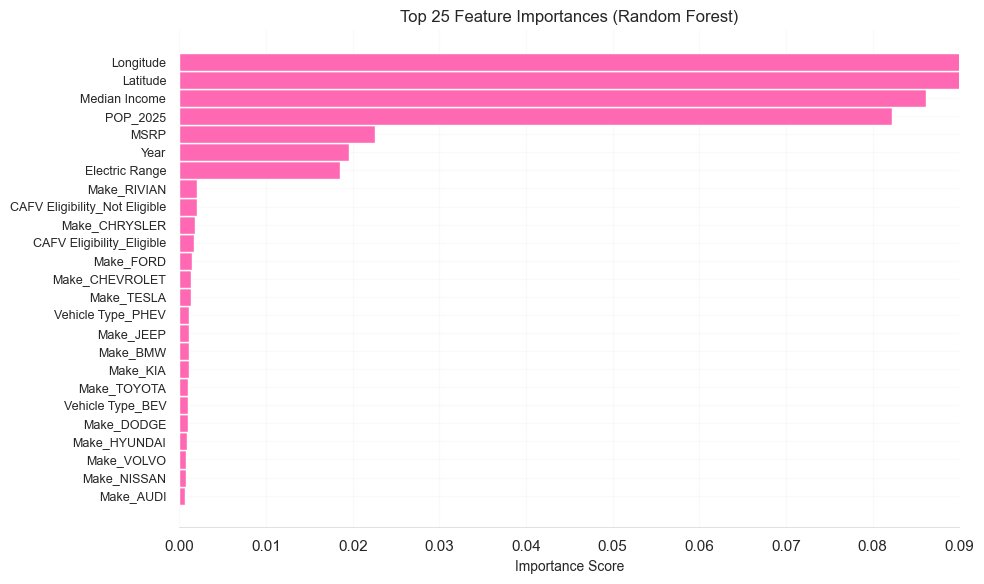

In [326]:

topN_sorted = topN[::-1]  # largest on top

plt.figure(figsize=(10, 6))

y_pos = range(len(topN_sorted))

plt.barh(
    y=y_pos,
    width=topN_sorted.values,
    color='hotpink',
    edgecolor='w',
    height=1.0   # bars touch each other
)

plt.yticks(y_pos, topN_sorted.index, fontsize=9)
plt.title(f"Top {N} Feature Importances (Random Forest)", fontsize=12)
plt.xlabel("Importance Score", fontsize=10)
plt.xlim(0,0.09)

# Aesthetic cleanup
ax = plt.gca()
for side in ['right', 'top', 'left']:
    ax.spines[side].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgray')

plt.grid(alpha=0.1)
plt.tight_layout()

plt.savefig("Figures/Cluster_Fig10.png")
plt.show()

#### Cross Validation

In [328]:
# 342s (5.7m)
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
reports = []

for train_idx, val_idx in skf.split(X_train_prep, y_train):
    X_tr, X_val = X_train_prep[train_idx], X_train_prep[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] 

    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_val)

    print(f"\n--- Fold {fold} ---")
    report = classification_report(y_val, y_pred, output_dict=True)  # as dict
    reports.append(report)
    
    # print human-readable report
    print(classification_report(y_val, y_pred))
    
    fold += 1

# Optionally: aggregate metrics across folds
mean_accuracy = np.mean([r['accuracy'] for r in reports])
print("\nMean CV Accuracy across folds:", mean_accuracy)


--- Fold 1 ---
              precision    recall  f1-score   support

          -1       0.88      0.02      0.04       328
           0       0.92      0.87      0.90       135
           1       0.99      1.00      0.99       258
           2       0.94      0.96      0.95       214
           3       0.88      0.84      0.86       170
           4       0.94      0.95      0.94       552
           5       0.93      0.94      0.93       353
           6       0.95      0.84      0.89       326
           7       0.74      0.82      0.78        74
           8       0.78      0.95      0.86        96
           9       0.77      0.85      0.81       208
          10       0.94      0.91      0.93       291
          11       0.97      0.99      0.98       260
          12       0.98      0.94      0.96       632
          13       0.75      0.89      0.81       161
          14       0.88      0.86      0.87       276
          15       0.98      0.93      0.95       482
          1

In [330]:
# 168s (2.8m)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Your memory-safe RF
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print("CV Accuracy scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))


CV Accuracy scores: [0.87545389 0.87441643 0.86933292 0.87228634 0.87734405]
Mean CV Accuracy: 0.8737667269965668
Std Dev: 0.0027537640309181705


#### Confusion Matrix (Not useful for 274 clusters)

In [34]:
# 53s
# RF fit for X_train
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test  = rf.predict(X_test)

In [38]:
# 437s
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# Train predictions
y_pred_train = rf.predict(X_train)

# cv predictions (5-fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=skf, n_jobs=-1)

# Test predictions
y_pred_test = rf.predict(X_test)

# Confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_cv    = confusion_matrix(y_train, y_pred_cv)
cm_test  = confusion_matrix(y_test, y_pred_test)


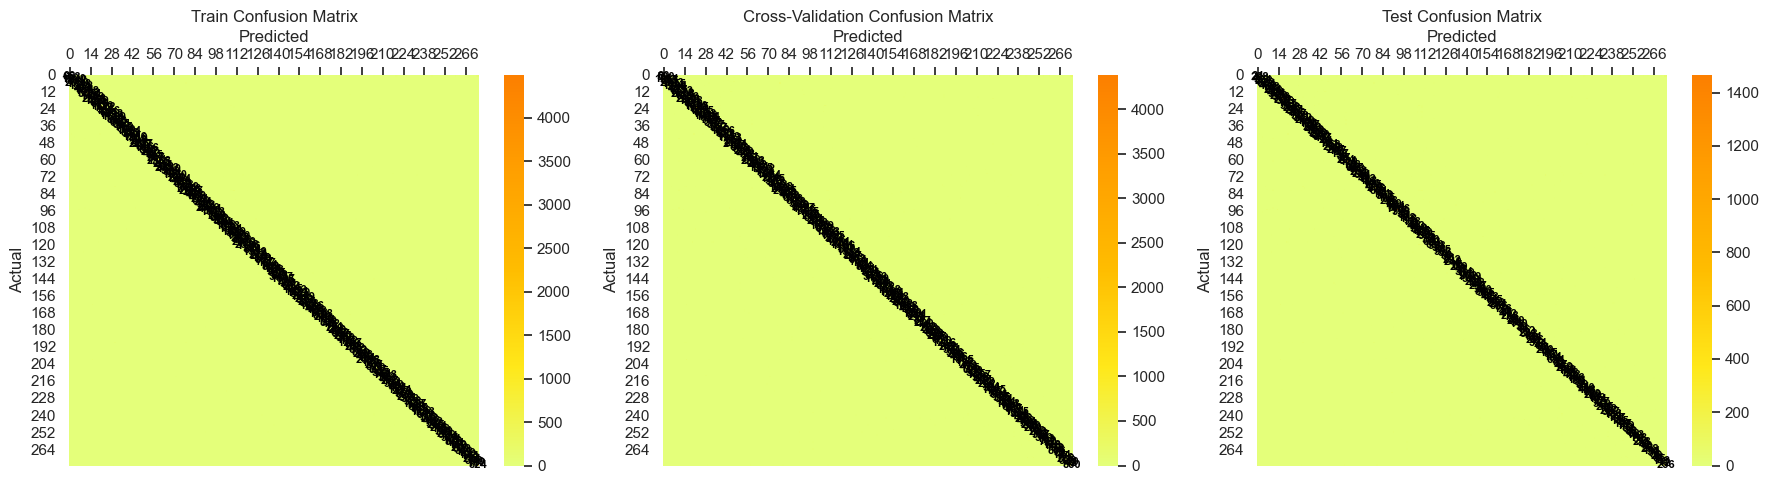

In [54]:
# 71s
# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

diag_mask = np.zeros_like(cm, dtype=bool)
np.fill_diagonal(diag_mask, True)

annot = np.full_like(cm, "", dtype=object)
for i in range(len(cm)):
    annot[i, i] = cm[i, i]   # only diagonal gets a number
    
titles = ["Train Confusion Matrix", "Cross-Validation Confusion Matrix", "Test Confusion Matrix"]
cms = [cm_train, cm_cv, cm_test]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=False, fmt="", cmap="Wistia", ax=ax)
    for i in range(cm.shape[0]):
        ax.text(
            i + 0.5, i + 0.5,          # center of each diagonal cell
            f"{cm[i, i]}",            # diagonal value
            ha="center", va="center",
            fontsize=8,              # <<< CHANGE FONTSIZE HERE
            color="black",
            fontweight="bold"
        )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
plt.tight_layout()
plt.show()

#### Cluster Size vs. Accuracy

In [331]:
# Put test labels into a DataFrame
df_test = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_test
})

# Compute cluster size (in test set)
cluster_sizes = df_test["y_true"].value_counts()

# Compute per-cluster accuracy
cluster_accuracy = df_test.groupby("y_true") \
                          .apply(lambda g: (g["y_true"] == g["y_pred"]).mean())

# Combine into one DataFrame
cluster_stats = pd.DataFrame({
    "cluster_size": cluster_sizes,
    "cluster_accuracy": cluster_accuracy
}).reset_index().rename(columns={"index": "cluster"})

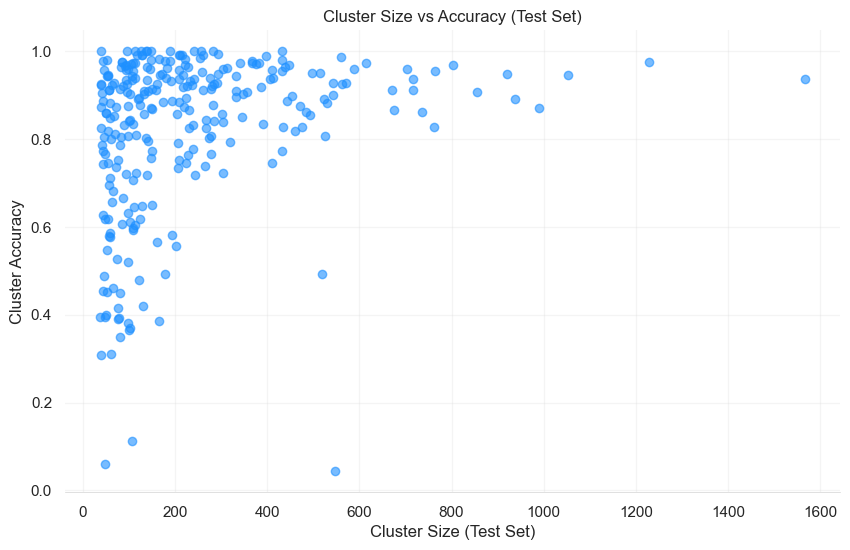

In [332]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_stats["cluster_size"],
    cluster_stats["cluster_accuracy"],
    c='dodgerblue',
    alpha=0.6,
)

plt.xlabel("Cluster Size (Test Set)")
plt.ylabel("Cluster Accuracy")
plt.title("Cluster Size vs Accuracy (Test Set)")

[plt.gca().spines[side].set_visible(False) for side in ['right', 'top', 'left']]
plt.gca().spines['bottom'].set_linewidth(0.5), plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(alpha=0.2)
plt.savefig("Figures/Cluster_Fig11.png")

plt.show()

#### UMAP Error Map

In [333]:
geo_econ = joblib.load("UMAP/geo_econ_umap.joblib")  # contains geo_umap_0, geo_umap_1, geo_cluster, etc.
X_test  = joblib.load("UMAP/X_test_prep.joblib")
y_test    = joblib.load("UMAP/y_test.joblib")
y_pred_test

array([215.,  19.,  50., ...,  59.,  59., 234.])

In [334]:
# Select only test rows from geo_econ
umap_test = geo_econ.loc[y_test.index].copy()

# Add correctness/error column
umap_test["correct"] = (y_test == y_pred_test).astype(int)
umap_test["error"] = 1 - umap_test["correct"]

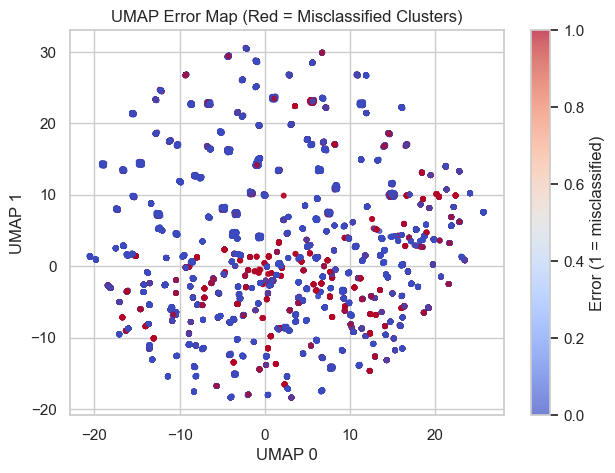

In [335]:
plt.figure(figsize=(7, 5))

plt.scatter(
    umap_test["geo_umap_0"],
    umap_test["geo_umap_1"],
    c=umap_test["error"],
    cmap="coolwarm",       # blue = correct, red = incorrect
    alpha=0.7,
    s=10
)

plt.title("UMAP Error Map (Red = Misclassified Clusters)")
plt.xlabel("UMAP 0")
plt.ylabel("UMAP 1")
plt.colorbar(label="Error (1 = misclassified)")
plt.savefig("Figures/Cluster_Fig12.png")
plt.show()

In [336]:
cluster_stats = pd.DataFrame({
    "cluster_size": y_test.value_counts(),
    "cluster_accuracy": df_test.groupby("y_true").apply(lambda g: (g["y_true"]==g["y_pred"]).mean())
})
cluster_stats_sorted = cluster_stats.sort_values(by="cluster_accuracy", ascending=False)

print(f'First 10:\n{cluster_stats_sorted.head(10)}\n')
print(f'Last 10:\n{cluster_stats_sorted.tail(10)}\n')

First 10:
     cluster_size  cluster_accuracy
270           113               1.0
54            147               1.0
168           283               1.0
130           240               1.0
260            40               1.0
34            127               1.0
36            256               1.0
269            95               1.0
163           136               1.0
1             431               1.0

Last 10:
      cluster_size  cluster_accuracy
 45            166          0.385542
 196            97          0.381443
 127           103          0.368932
 136           101          0.366337
 267            80          0.350000
 253            61          0.311475
 272            39          0.307692
 165           107          0.112150
 175            49          0.061224
-1             547          0.043876



#### Parity Plot

In [337]:
# Count number of points per cluster
actual_sizes = y_test.value_counts().sort_index()    # actual cluster sizes
predicted_sizes = pd.Series(y_pred_test).value_counts().sort_index()  # predicted cluster sizes

# Combine into DataFrame
cluster_size_df = pd.DataFrame({
    "actual_size": actual_sizes,
    "predicted_size": predicted_sizes
}).fillna(0)  # fill missing clusters with 0

In [338]:
# x = actual cluster sizes, y = predicted cluster sizes
x = cluster_size_df["actual_size"]
y = cluster_size_df["predicted_size"]

# Linear fit (degree=1)
slope, intercept = np.polyfit(x, y, 1)

print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}")

Slope: 0.930, Intercept: 16.372


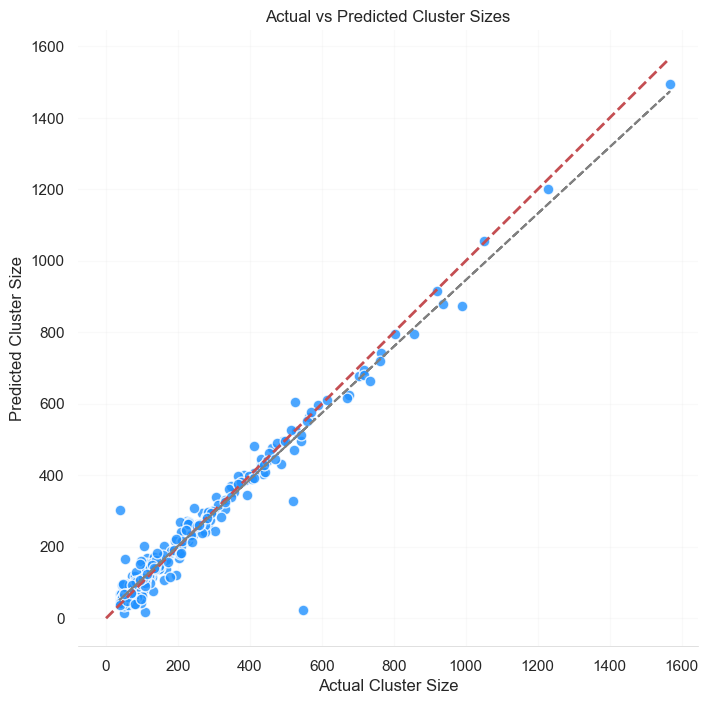

In [339]:
plt.figure(figsize=(8, 8))

plt.scatter(
    cluster_size_df["actual_size"], 
    cluster_size_df["predicted_size"], 
    alpha=0.8, 
    s=60, 
    color="dodgerblue",
    edgecolor="w",
    linewidth=1.0,
)

# Diagonal line: perfect prediction
max_val = max(cluster_size_df["actual_size"].max(), cluster_size_df["predicted_size"].max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

# True line
plt.plot(x, slope*x + intercept, color='gray', linestyle='--', linewidth=1.5, label=f"Fit: y={slope:.2f}x + {intercept:.1f}")

plt.xlabel("Actual Cluster Size")
plt.ylabel("Predicted Cluster Size")
plt.title("Actual vs Predicted Cluster Sizes")

[plt.gca().spines[side].set_visible(False) for side in ['right', 'top', 'left']]
plt.gca().spines['bottom'].set_linewidth(0.5), plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(alpha=0.1)

plt.savefig("Figures/Cluster_Fig13.png")
plt.show()